# **Klasifikasi Tipe Kepribadian MBTI menggunakan XGBoostClassifier**

Nama : Daffa Hanif Durachman

NIM : 21.11.4470

Kelas : 21IF

# 1 | Load Library and Dataset

In [ ]:
!pip install xgboost==2.0.3 scikit-learn==1.2.2

In [ ]:
import pandas as pd # Untuk manipulasi dan analisis data
import numpy as np # Untuk komputasi numerik
import matplotlib.pyplot as plt # Untuk visualisasi dat
import seaborn as sns # Untuk visualisasi data
import xgboost as xgb # Model klasifikasi XGBoost
import sklearn # Library utama untuk machine learning
from xgboost import XGBClassifier # Model klasifikasi XGBoost
from sklearn.preprocessing import LabelEncoder # Untuk melakukan encoding label
from sklearn.preprocessing import StandardScaler # Untuk melakukan penskalaan fitur
from sklearn.model_selection import train_test_split # Untuk membagi data menjadi training dan testing set
from sklearn.model_selection import RandomizedSearchCV # Untuk mencari hyperparameter terbaik
from sklearn.model_selection import GridSearchCV # Untuk mencari hyperparameter terbaik
from sklearn.feature_selection import mutual_info_classif # Untuk mengukur seberapa informatif suatu fitur terhadap target variable
from sklearn.model_selection import cross_validate # Untuk mengevaluasi model
from sklearn.model_selection import validation_curve # Untuk mengevaluasi model
from sklearn.model_selection import learning_curve # Untuk mengevaluasi model
from sklearn.metrics import confusion_matrix # Untuk membuat confusion matriks
from sklearn.metrics import ConfusionMatrixDisplay # Untuk membuat visualisasi confusion matriks
from sklearn.metrics import roc_curve # Untuk membuat grafik ROC
from sklearn.metrics import accuracy_score, f1_score, classification_report # Untuk evaluasi performa model

In [ ]:
print(f"XGBoost version: {xgb.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")

XGBoost version: 2.0.3
scikit-learn version: 1.2.2


In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d stealthtechnologies/predict-people-personality-types --force # Download the dataset

Dataset URL: https://www.kaggle.com/datasets/stealthtechnologies/predict-people-personality-types
License(s): MIT
  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 92.8MB/s]


In [ ]:
!unzip predict-people-personality-types.zip # Unzip the dataset

Archive:  predict-people-personality-types.zip
replace data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data.csv                


In [ ]:
data = pd.read_csv('/content/data.csv')

#2 | Exploratory Data Analysis

## Data Read dan Stats

In [ ]:
data

,Age,Gender,Education,Introversion Score,Sensing Score,Thinking Score,Judging Score,Interest,Personality
0,21.0,Female,1,5.89208,2.144395,7.32363,5.462224,Arts,ENTP
1,24.0,Female,1,2.48366,3.206188,8.06876,3.765012,Unknown,INTP
2,26.0,Female,1,7.02910,6.469302,4.16472,5.454442,Others,ESFP
3,30.0,Male,0,5.46525,4.179244,2.82487,5.080477,Sports,ENFJ
4,31.0,Female,0,3.59804,6.189259,5.31347,3.677984,Others,ISFP
...,...,...,...,...,...,...,...,...,...
43739,26.0,Male,1,8.88656,5.118399,8.48784,5.331942,Arts,ENTP
43740,29.0,Male,0,2.71470,6.851956,0.25519,3.623678,Unknown,ISFP
43741,25.0,Female,0,2.00982,6.544036,6.63911,6.201555,Technology,ISTJ
43742,23.0,Male,0,7.23553,4.876780,2.41671,4.654016,Arts,ENFP


In [ ]:
data.describe() # Statistik data

,Age,Education,Introversion Score,Sensing Score,Thinking Score,Judging Score
count,43744.000000,43744.000000,43744.000000,43744.000000,43744.000000,43744.000000
mean,27.437203,0.229014,4.588349,5.780074,5.419131,5.391041
std,4.893805,0.420203,2.902628,1.241648,2.900785,1.442413
min,18.000000,0.000000,0.000150,0.000000,0.000320,0.000000
25%,24.000000,0.000000,2.067020,4.953340,2.895750,4.511842
50%,27.000000,0.000000,4.261680,6.162928,5.769870,5.771635
75%,30.000000,0.000000,7.085002,6.622978,7.923503,6.409583
max,52.000000,1.000000,9.999920,9.803837,9.999770,10.000000


## Deskripsi Fitur dan Cek Type Data

* Usia: Variabel kontinu yang mewakili usia individu.

* Jenis Kelamin: Variabel kategorikal yang menunjukkan jenis kelamin individu. Nilainya adalah 'Laki-laki' dan 'Perempuan'.

* Pendidikan: Variabel biner, nilai 1 menunjukkan individu memiliki pendidikan setidaknya setingkat pascasarjana (atau lebih tinggi), dan 0 menunjukkan pendidikan sarjana, tingkat sekolah menengah atau tidak berpendidikan.

* Minat: Variabel kategorikal yang mewakili area minat utama individu.

* Skor Introversi: Variabel kontinu yang berkisar dari 0 hingga 10, mewakili kecenderungan individu terhadap introversi versus ekstroversi. Skor yang lebih tinggi menunjukkan kecenderungan yang lebih besar terhadap ekstroversi.

* Skor Sensing: Variabel kontinu yang berkisar dari 0 hingga 10, mewakili preferensi individu untuk sensing versus intuisi. Skor yang lebih tinggi menunjukkan preferensi untuk sensing.

* Skor Thinking: Variabel kontinu yang berkisar dari 0 hingga 10, menunjukkan preferensi individu untuk berpikir versus merasa. Skor yang lebih tinggi menunjukkan preferensi untuk berpikir.

* Skor Judging: Variabel kontinu yang berkisar dari 0 hingga 10, mewakili preferensi individu untuk menilai versus mempersepsi. Skor yang lebih tinggi menunjukkan preferensi untuk menilai.

* Kepribadian: Target yang berisi Tipe Kepribadian Orang.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43744 entries, 0 to 43743
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 43744 non-null  float64
 1   Gender              43744 non-null  object 
 2   Education           43744 non-null  int64  
 3   Introversion Score  43744 non-null  float64
 4   Sensing Score       43744 non-null  float64
 5   Thinking Score      43744 non-null  float64
 6   Judging Score       43744 non-null  float64
 7   Interest            43744 non-null  object 
 8   Personality         43744 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 3.0+ MB


## Check Shape sebelum data dibersihkan

In [ ]:
data.shape

(43744, 9)

## Visualisasi distribusi data menggunakan PieChart dan BarPlot.

<ipython-input-12-3dc52a467e82>:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')


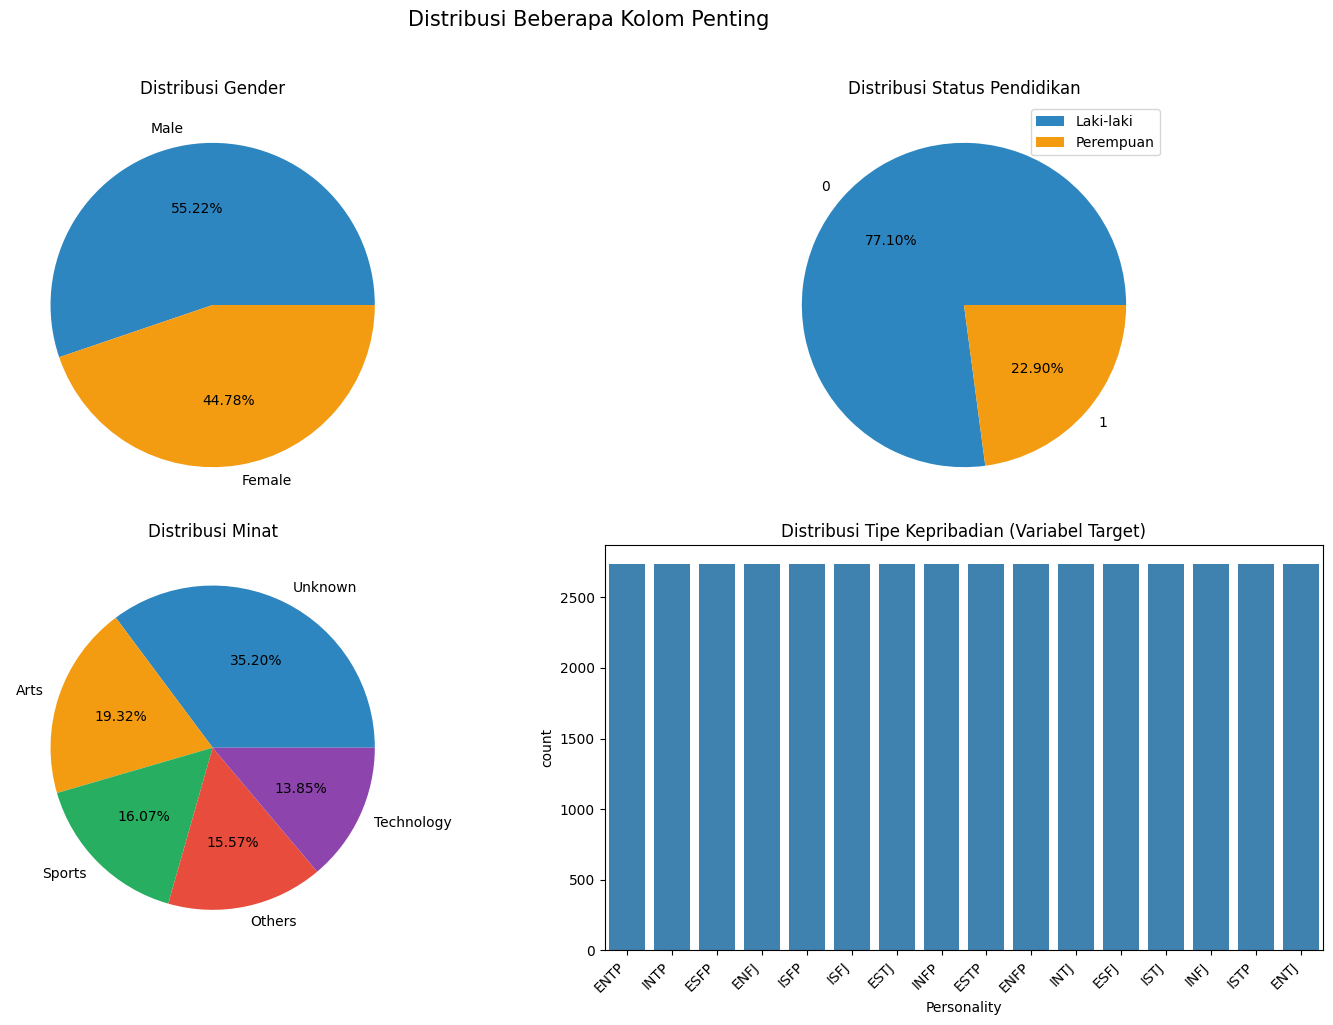

In [ ]:
# Visualisasi Distribusi Data
jumlah_gender = data['Gender'].value_counts().reset_index()
jumlah_pendidikan = data['Education'].value_counts().reset_index()
jumlah_minat = data['Interest'].value_counts().reset_index()

# Khusus untuk kepribadian, kita perlu memastikan data dihitung dengan benar
personality_counts = data['Personality'].value_counts()
jumlah_kepribadian = pd.DataFrame({
    'Personality': personality_counts.index,
    'count': personality_counts.values
})

# Membuat figure dengan 2x2 subplots
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 2)

# Distribusi Gender
ax1 = fig.add_subplot(gs[0, 0])
ax1.pie(x=jumlah_gender['count'], labels=jumlah_gender['Gender'], autopct='%.2f%%',
        colors=['#2E86C1', '#F39C12'])
ax1.set_title('Distribusi Gender')

# Distribusi Pendidikan
ax2 = fig.add_subplot(gs[0, 1])
ax2.pie(x=jumlah_pendidikan['count'], labels=jumlah_pendidikan['Education'], autopct='%.2f%%',
        colors=['#2E86C1', '#F39C12'])
ax2.legend(['Laki-laki', 'Perempuan'])
ax2.set_title('Distribusi Status Pendidikan')

# Distribusi Minat
ax3 = fig.add_subplot(gs[1, 0])
colors_minat = ['#2E86C1', '#F39C12', '#27AE60', '#E74C3C', '#8E44AD']
ax3.pie(x=jumlah_minat['count'], labels=jumlah_minat['Interest'], autopct='%.2f%%',
        colors=colors_minat)
ax3.set_title('Distribusi Minat')

# Distribusi Kepribadian - dengan perbaikan untuk data kategorikal
ax4 = fig.add_subplot(gs[1, 1])
sns.barplot(
    x='Personality',
    y='count',
    data=jumlah_kepribadian,
    ax=ax4,
    color='#2E86C1',
    order=personality_counts.index  # Memastikan urutan sesuai frekuensi
)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
ax4.set_title('Distribusi Tipe Kepribadian (Variabel Target)')
ax4.set_ylabel('count')

# Mengatur judul utama dan spacing
plt.suptitle('Distribusi Beberapa Kolom Penting', fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

* Education berdasarkan gender terlihat lumayan ketimpangan dengan jumlah 77.10% untuk Laki-laki dan 22.90% untuk Perempuan.
* Gender hampir balance.
* Sekitar 35.20% orang didalam dataset ini tidak mengetahui interest apa yang mereka miliki atau belum siap membagikan pengalamanya.
* Terdapat 16 tipe kepribadian dengan total yang sama dan ini nanti yang akan menjadi variabel target.

In [ ]:
# Untuk memverifikasi data
print("Distribusi Kepribadian:")
print(jumlah_kepribadian)

Distribusi Kepribadian:
   Personality  count
0         ENTP   2734
1         INTP   2734
2         ESFP   2734
3         ENFJ   2734
4         ISFP   2734
5         ISFJ   2734
6         ESTJ   2734
7         INFP   2734
8         ESTP   2734
9         ENFP   2734
10        INTJ   2734
11        ESFJ   2734
12        ISTJ   2734
13        INFJ   2734
14        ISTP   2734
15        ENTJ   2734


## Visualisasi distribusi data 'Proporsi Pendidikan Berdasarkan Jenis Kelamin' menggunakan BarPlot

<ipython-input-14-d9fa69b4a369>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cate, y=props, palette='magma')


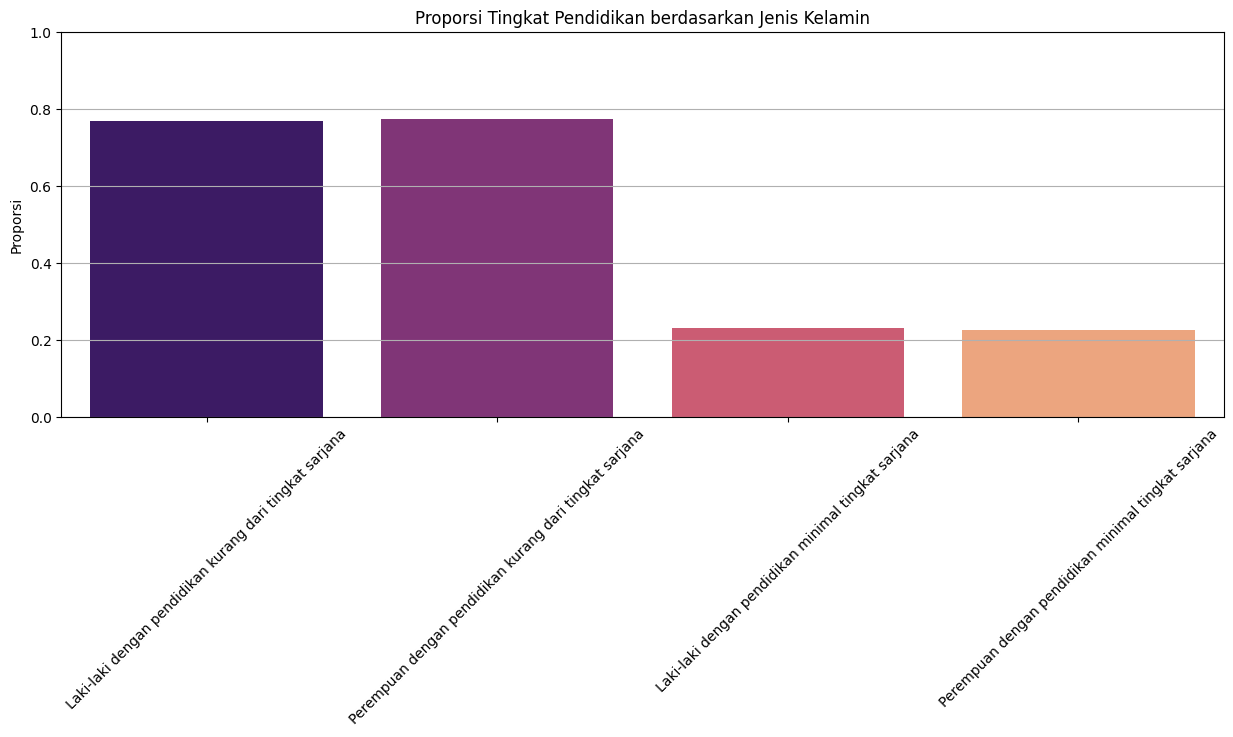

In [ ]:
c = data.loc[(data['Education'] == 0) & (data['Gender'] == 'Male')].shape[0]
c1 = data.loc[(data['Education'] == 0) & (data['Gender'] == 'Female')].shape[0]
c2 = data.loc[(data['Education'] == 1) & (data['Gender'] == 'Male')].shape[0]
c3 = data.loc[(data['Education'] == 1) & (data['Gender'] == 'Female')].shape[0]
total_counts = data['Gender'].value_counts()
props = [
    c / total_counts['Male'],
    c1 / total_counts['Female'],
    c2 / total_counts['Male'],
    c3 / total_counts['Female']
]
cate = [
    'Laki-laki dengan pendidikan kurang dari tingkat sarjana',
    'Perempuan dengan pendidikan kurang dari tingkat sarjana',
    'Laki-laki dengan pendidikan minimal tingkat sarjana',
    'Perempuan dengan pendidikan minimal tingkat sarjana'
]
plt.figure(figsize=(15, 5))
sns.barplot(x=cate, y=props, palette='magma')
plt.title('Proporsi Tingkat Pendidikan berdasarkan Jenis Kelamin')
plt.ylabel('Proporsi')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

## Visualisasi jumlah distribusi kolom Interest berdasarkan kolom Jenis kelamin

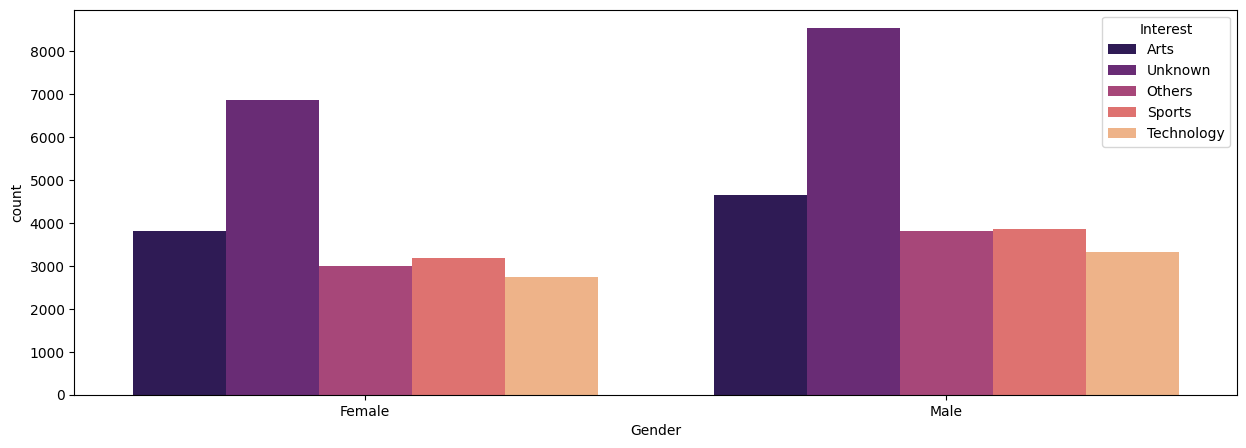

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(data=data,x='Gender',hue='Interest',palette='magma')
plt.show()

## Introversion, Sensing, Thinking, dan Judging Score berdasarkan tiap MBTI

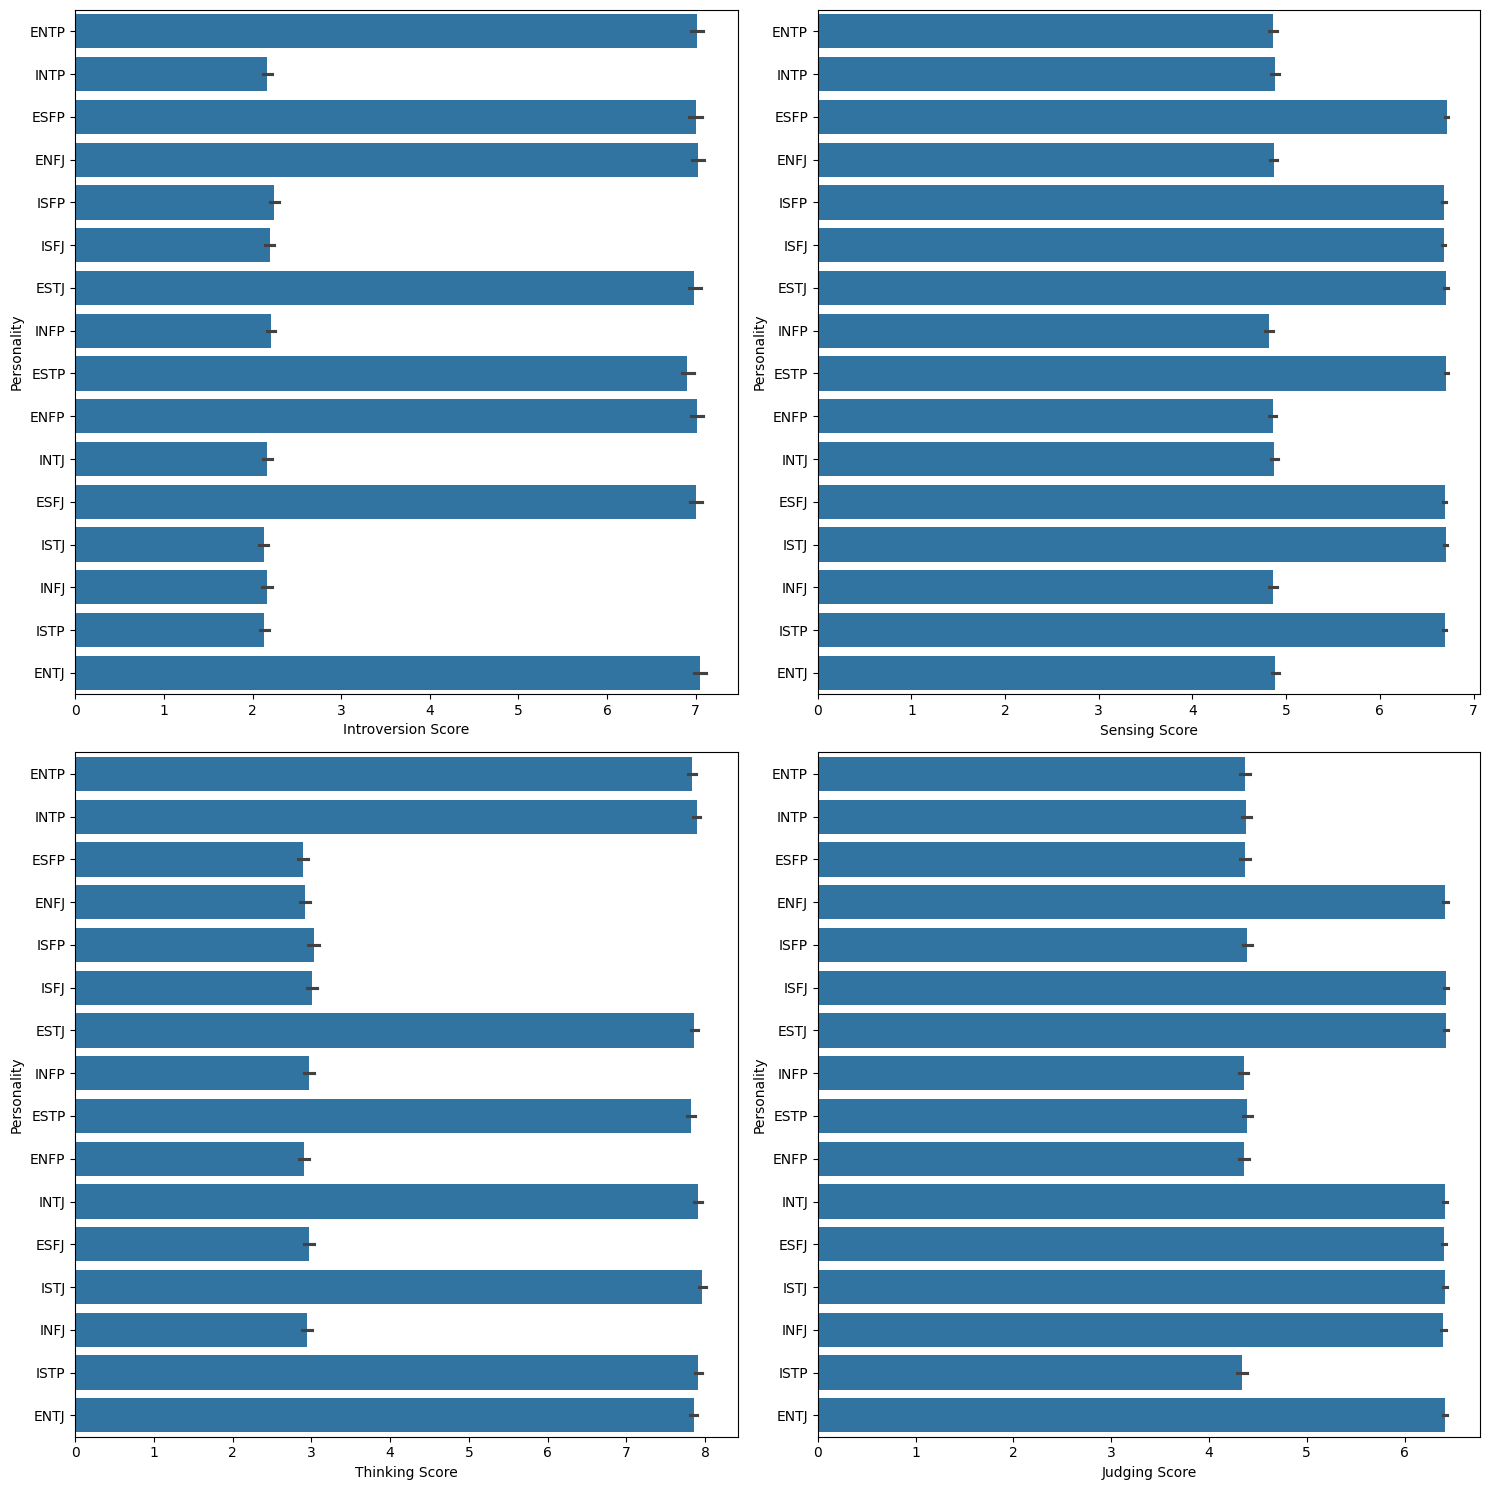

In [ ]:
fig,ax=plt.subplots(2,2,figsize=(15,15))
sns.barplot(data=data, y='Personality', x='Introversion Score', estimator='mean',ax=ax[0][0])
sns.barplot(data=data, y='Personality', x='Sensing Score', estimator='mean',ax=ax[0][1])
sns.barplot(data=data, y='Personality', x='Thinking Score', estimator='mean',ax=ax[1][0])
sns.barplot(data=data, y='Personality', x='Judging Score', estimator='mean',ax=ax[1][1])
plt.tight_layout()
plt.show()

* Analisis Skor Introvert:

Tipe INTJ dan INTP memiliki skor introvert tertinggi, sedangkan ENFJ dan ENTP memiliki skor yang lebih rendah, sejalan dengan sifat ekstrovert mereka. Tipe dengan huruf "I" cenderung lebih introvert, sedangkan tipe dengan huruf "E" lebih ekstrovert.

* Analisis Skor Sensing:

Tipe ESTJ dan ISTJ memiliki skor sensing tertinggi, menunjukkan preferensi pada informasi konkret. Sebaliknya, tipe dengan "N" (intuisi) seperti INTJ, ENTP, dan INFJ memiliki skor sensing yang lebih rendah, menunjukkan kecenderungan pada intuisi.

* Korelasi Antara Introvert dan Sensing:

Tipe sensing ekstrovert seperti ESTP dan ESFP menunjukkan skor sensing tinggi dan introvert rendah, sedangkan tipe intuitif introvert seperti INFJ dan INTJ memiliki skor sensing rendah dan introvert tinggi.

* Pola Tipe Kepribadian:

Tipe sensing seperti ESTJ, ISTJ, dan ESFJ cenderung memiliki skor introvert lebih rendah dan skor sensing lebih tinggi, karena sensing sering kali dikaitkan dengan pendekatan praktis. Sebaliknya, tipe intuitif introvert seperti INTJ dan INFJ lebih menyukai pemikiran internal dan abstrak.

* Skor Pemikiran (Thinking):

INTP, ENTJ, dan INTJ memiliki skor thinking tertinggi, menandakan preferensi pada logika dalam pengambilan keputusan. Sebaliknya, ESFJ, ISFJ, dan INFJ memiliki skor thinking lebih rendah, menunjukkan kecenderungan pada pengambilan keputusan berbasis perasaan.

* Skor Penilaian (Judging):

ESTJ dan ISTJ memiliki skor judging tertinggi, mencerminkan preferensi terhadap struktur dan perencanaan. Tipe seperti ENFP dan ESFP memiliki skor lebih rendah, menunjukkan preferensi pada fleksibilitas dan spontanitas.

## Jumlah tingkat Pendidikan berdasarkan tiap MBTI pada setiap Gender

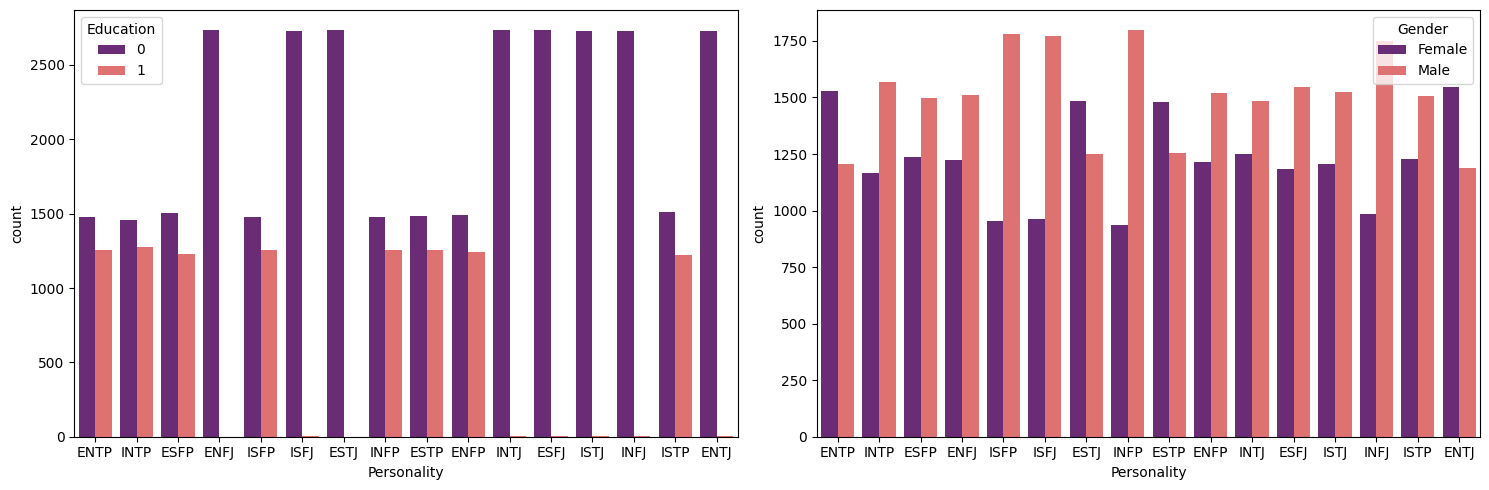

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
sns.countplot(data=data,x='Personality',hue='Education',palette='magma',ax=ax[0])
sns.countplot(data=data,x='Personality',hue='Gender',palette='magma',ax=ax[1])
plt.tight_layout()
plt.show()

##  Visualisasi BoxPlot untuk mendeteksi Outliers

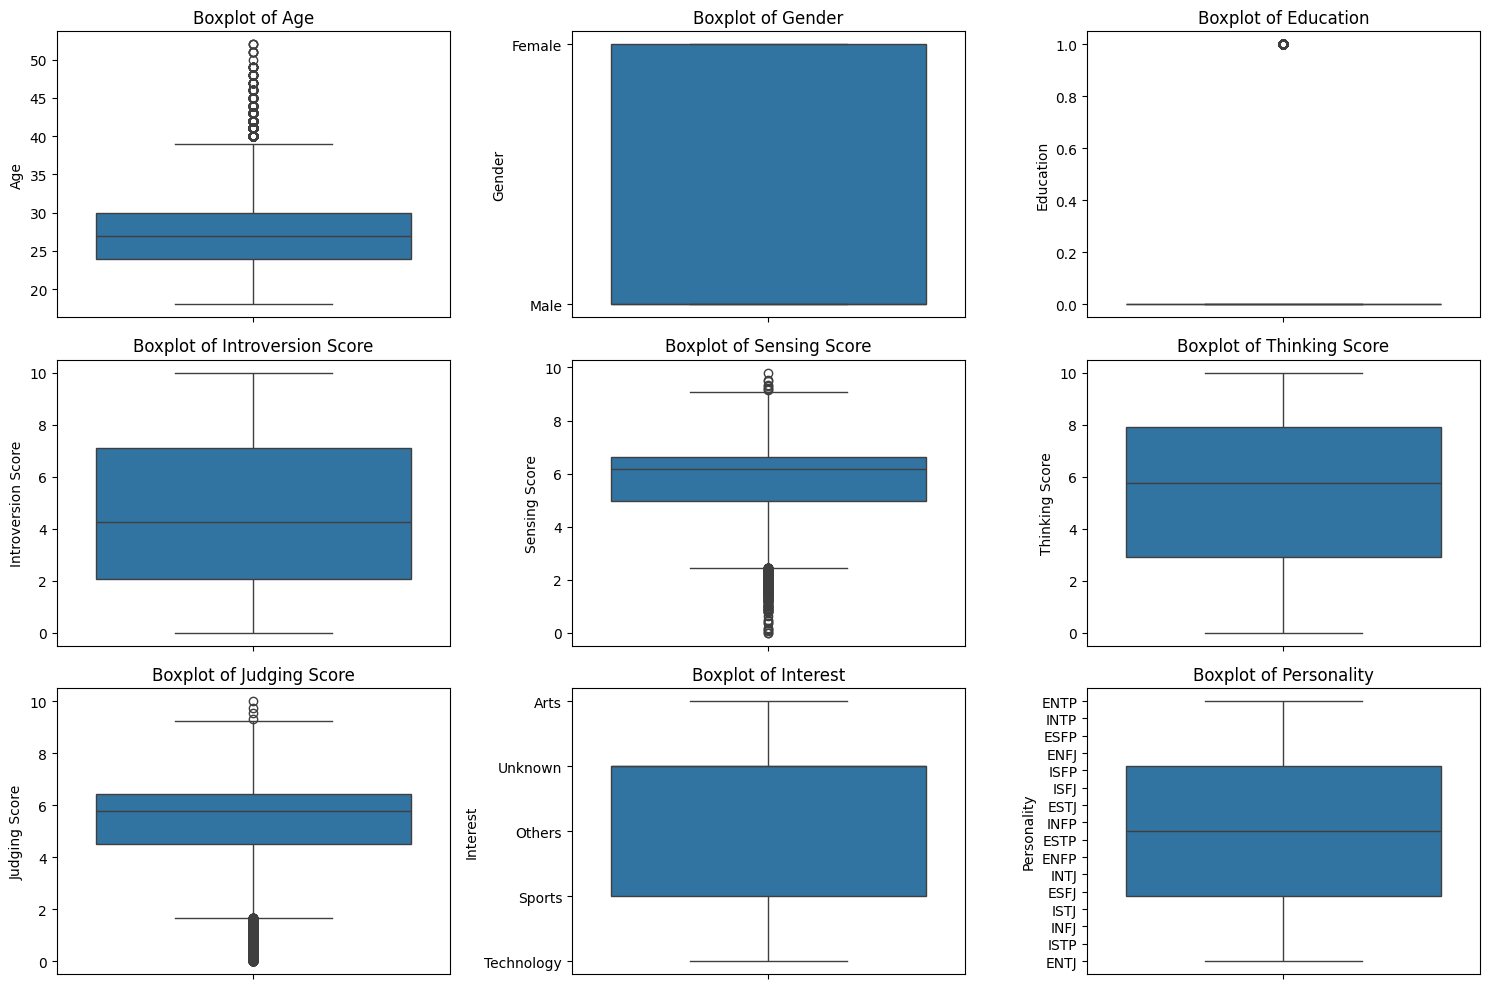

In [ ]:
plt.figure(figsize=(15, 10))

# Adjust the subplot grid to accommodate all columns
# The dataset has 9 columns, needs at least (3,3) or (2,5) subplot grid.
# Here we use a 3x3 grid
for i, col in enumerate(data):
    plt.subplot(3, 3, i + 1)  # Changed to 3 rows, 3 columns
    sns.boxplot(y=data[col])
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

#3 | Pre-Processing Data

## Drop duplicated data

In [ ]:
data_with_duplicates = data.shape[0]
data = data.drop_duplicates()
data_without_duplicates = data.shape[0]
print(f"Jumlah baris sebelum duplikasi: {data_with_duplicates}")
print(f"Jumlah baris setelah duplikasi: {data_without_duplicates}")

Jumlah baris sebelum duplikasi: 43744
Jumlah baris setelah duplikasi: 42716


## Check null

In [ ]:
data.isnull().any() # Tidak ada nilai null

,0
Age,False
Gender,False
Education,False
Introversion Score,False
Sensing Score,False
Thinking Score,False
Judging Score,False
Interest,False
Personality,False


## Encoding menggunakan LabelEncoder dan Check Data

In [ ]:
le=LabelEncoder()
for col in data.columns[data.dtypes=='object']:
    data[col]=le.fit_transform(data[col])
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 42716 entries, 0 to 43743
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 42716 non-null  float64
 1   Gender              42716 non-null  int64  
 2   Education           42716 non-null  int64  
 3   Introversion Score  42716 non-null  float64
 4   Sensing Score       42716 non-null  float64
 5   Thinking Score      42716 non-null  float64
 6   Judging Score       42716 non-null  float64
 7   Interest            42716 non-null  int64  
 8   Personality         42716 non-null  int64  
dtypes: float64(5), int64(4)
memory usage: 3.3 MB
None


<ipython-input-21-54a7d8a0dc09>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col]=le.fit_transform(data[col])
<ipython-input-21-54a7d8a0dc09>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col]=le.fit_transform(data[col])
<ipython-input-21-54a7d8a0dc09>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [ ]:
data.head()

,Age,Gender,Education,Introversion Score,Sensing Score,Thinking Score,Judging Score,Interest,Personality
0,21.0,0,1,5.89208,2.144395,7.32363,5.462224,0,3
1,24.0,0,1,2.48366,3.206188,8.06876,3.765012,4,11
2,26.0,0,1,7.02910,6.469302,4.16472,5.454442,1,5
3,30.0,1,0,5.46525,4.179244,2.82487,5.080477,2,0
4,31.0,0,0,3.59804,6.189259,5.31347,3.677984,1,13


## Check Shape setelah data bersih

In [ ]:
data.shape

(42716, 9)

## Drop dan Check Outliers

In [ ]:
def remove_outliers_iqr(data, column, factor=1.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR

    # Clipping instead of removing
    data[column] = np.clip(data[column], lower_bound, upper_bound)
    return data

# Example usage (assuming 'data' DataFrame from your code)
for col in ['Age', 'Sensing Score', 'Judging Score']:
    data = remove_outliers_iqr(data, col)

<ipython-input-24-91f8dc8dad04>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = np.clip(data[column], lower_bound, upper_bound)
<ipython-input-24-91f8dc8dad04>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = np.clip(data[column], lower_bound, upper_bound)
<ipython-input-24-91f8dc8dad04>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

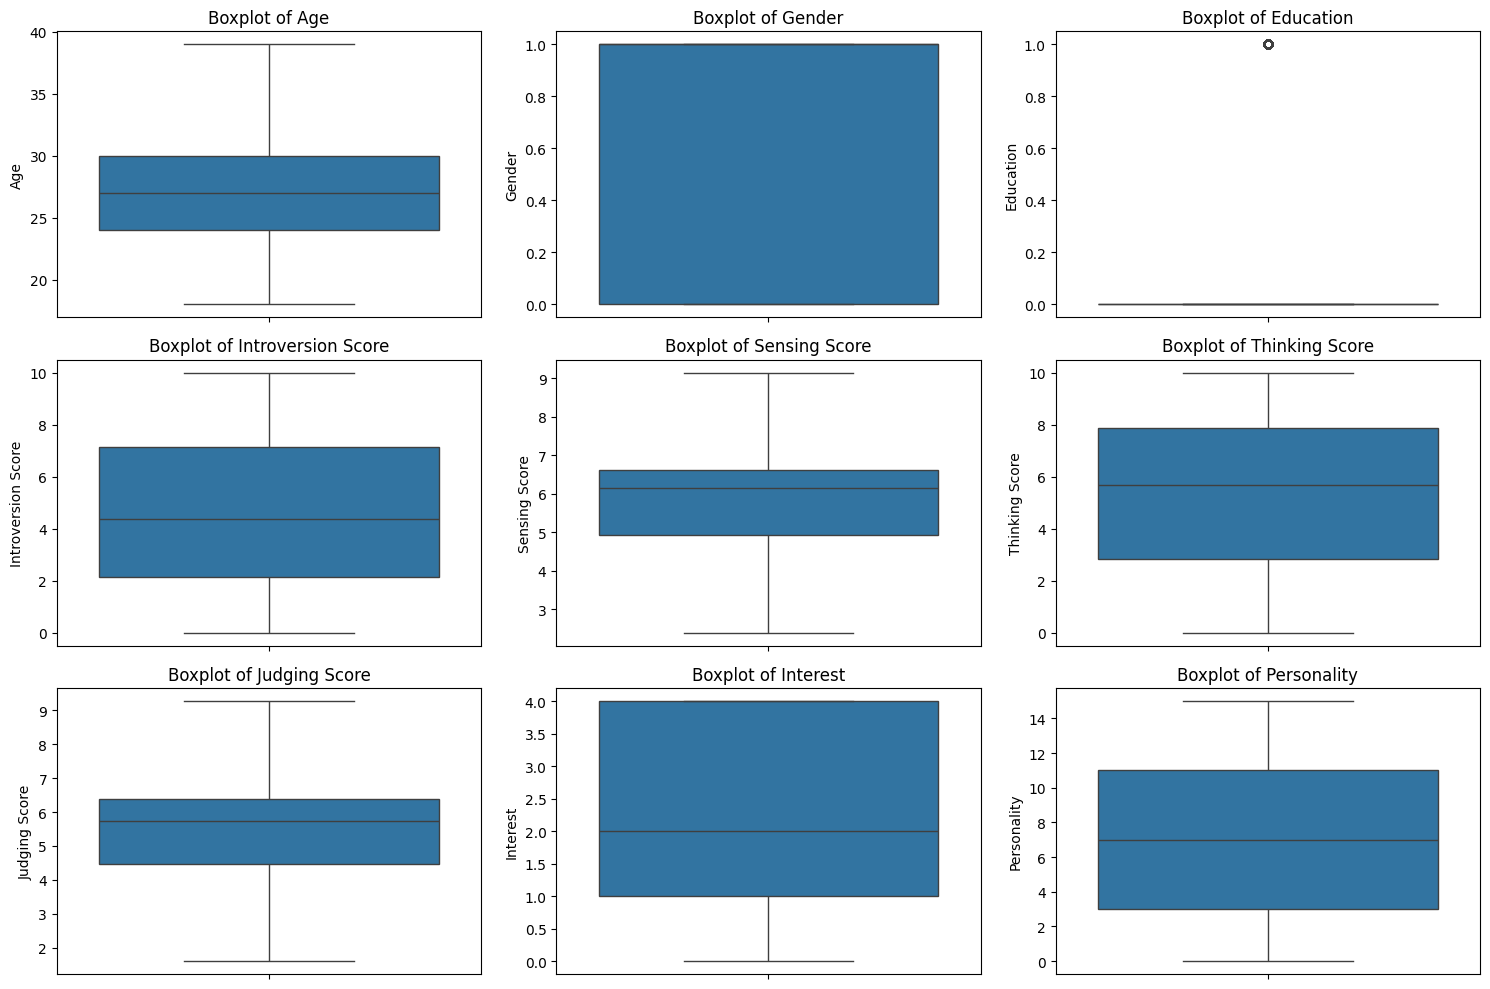

In [ ]:
plt.figure(figsize=(15, 10))

# Adjust the subplot grid to accommodate all columns
# The dataset has 9 columns, needs at least (3,3) or (2,5) subplot grid.
# Here we use a 3x3 grid
for i, col in enumerate(data):
    plt.subplot(3, 3, i + 1)  # Changed to 3 rows, 3 columns
    sns.boxplot(y=data[col])
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

* Boxplot dari Education memang sengaja tidak ditangani karena hanya berisi nilai 1 : graduate-level education (or higher) dan 0 :  indicates an undergraduate, high school level or Uneducated.

## Visualisasi korelasi menggunakan HeatMap  setelah data dibersihkan

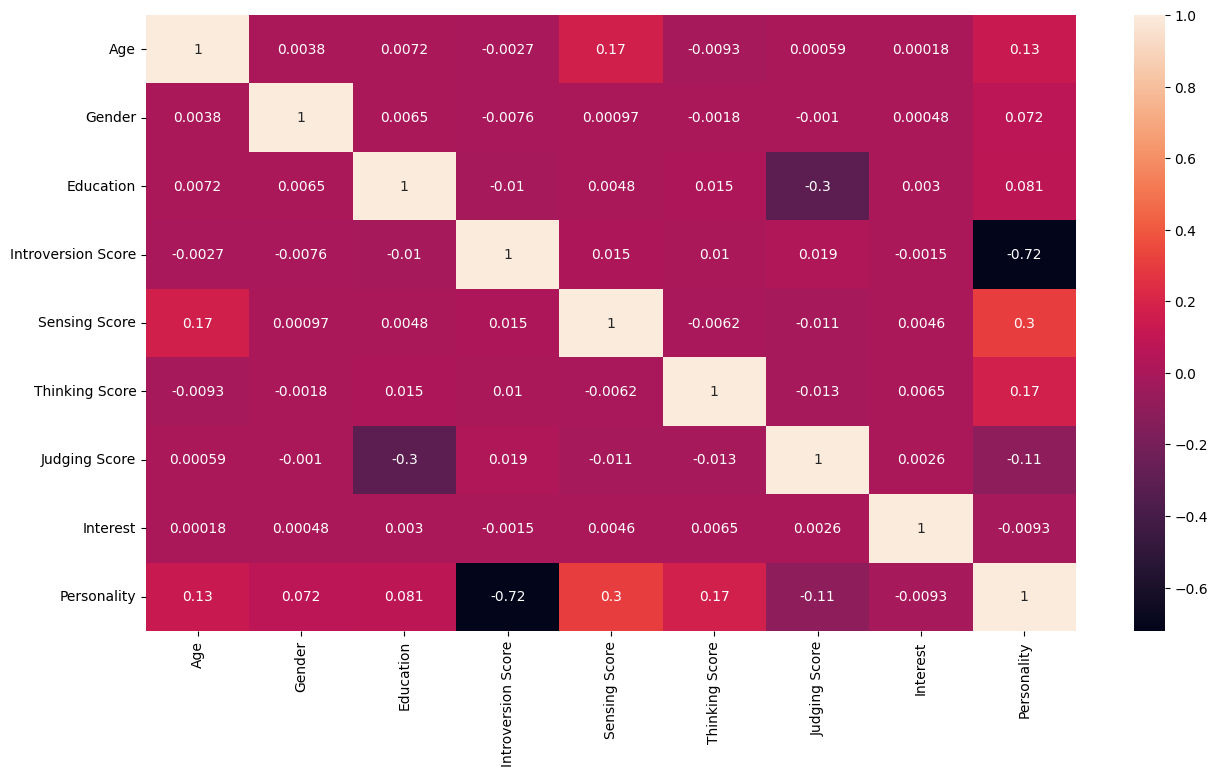

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(data.corr(),annot=True)
plt.show()

* Korelasi negatif terkuat (-0.72) terdapat antara "Introversion Score" dan "Personality"
* Korelasi positif moderat (0.3) terlihat antara "Sensing Score" dan "Personality"
* Korelasi negatif moderat (-0.3) terlihat antara "Education" dan "Judging Score"

# Mutual Information

In [ ]:
# Membagi data menjadi fitur (X) dan target (y)
X = data.drop(columns='Personality', axis=1) #drop Personality
y = data['Personality']

# Calculate mutual information
mutual_info = mutual_info_classif(X, y)

# Create a DataFrame to display the results
mutual_info_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mutual_info})
mutual_info_df = mutual_info_df.sort_values(by='Mutual Information', ascending=False)

mutual_info_df.head(15)

,Feature,Mutual Information
5,Thinking Score,0.590077
4,Sensing Score,0.540409
3,Introversion Score,0.531882
6,Judging Score,0.440609
2,Education,0.189428
0,Age,0.093325
7,Interest,0.022040
1,Gender,0.009544


## Splitting Data

In [ ]:
# Splitting data menggunakan Holdout Method
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    random_state=45,
                                                    stratify=y,
                                                    shuffle=True) # Stratify untuk menjaga proporsi kelas
# memastikan bahwa proporsi kelas dalam variabel target (y) tetap sama di data latih dan data uji.
# Misalnya, jika variabel target memiliki 60% kelas A dan 40% kelas B, proporsi yang sama akan dipertahankan di kedua subset (data latih dan data uji).

## Standard Scaler

In [ ]:
# Inisialisasi StandardScaler
scaler = StandardScaler()

# Fit dan transformasi data pelatihan
X_train_scaled = scaler.fit_transform(X_train)

# Transformasi data pengujian
X_test_scaled = scaler.transform(X_test)

#4 | Modelling

## XGBClassifier

* Menggunakan softmax untuk prediksi probabilitas multi-kelas
* Monitoring performa pada data training dan testing
* Implementasi early stopping untuk mencegah overfitting
* Parameter penting seperti jumlah pohon dan jumlah kelas sudah dikonfigurasi

In [ ]:
# Menyiapkan data validasi untuk monitoring performa model selama training
eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)]

# Inisialisasi model XGBoost untuk klasifikasi
xgb_cls = xgb.XGBClassifier(
    objective="multi:softmax",  # Menggunakan fungsi softmax karena ini adalah klasifikasi multi-kelas
    eval_metric="mlogloss",     # Menggunakan metric multiclass log loss untuk evaluasi performa
    num_class=16,              # Menentukan jumlah kelas output (16 tipe MBTI)
    n_estimators=100,          # Jumlah maksimal pohon keputusan yang akan dibuat
    random_state=45)           # Seed untuk reprodusibilitas hasil

# Melatih model XGBoost
xgb_cls.fit(
    X_train_scaled, y_train,   # Data training
    eval_set=eval_set,         # Dataset untuk evaluasi (training dan testing)
    early_stopping_rounds=5,    # Berhenti jika tidak ada peningkatan setelah 5 iterasi
    verbose=1)                 # Menampilkan progress training

[0]	validation_0-mlogloss:1.31420	validation_1-mlogloss:1.34066


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:1.02534	validation_1-mlogloss:1.05505
[2]	validation_0-mlogloss:0.84298	validation_1-mlogloss:0.87506
[3]	validation_0-mlogloss:0.71634	validation_1-mlogloss:0.75014
[4]	validation_0-mlogloss:0.62281	validation_1-mlogloss:0.65770
[5]	validation_0-mlogloss:0.55204	validation_1-mlogloss:0.58756
[6]	validation_0-mlogloss:0.49636	validation_1-mlogloss:0.53212
[7]	validation_0-mlogloss:0.45237	validation_1-mlogloss:0.48860
[8]	validation_0-mlogloss:0.41712	validation_1-mlogloss:0.45378
[9]	validation_0-mlogloss:0.38761	validation_1-mlogloss:0.42477
[10]	validation_0-mlogloss:0.36301	validation_1-mlogloss:0.40055
[11]	validation_0-mlogloss:0.34389	validation_1-mlogloss:0.38161
[12]	validation_0-mlogloss:0.32632	validation_1-mlogloss:0.36473
[13]	validation_0-mlogloss:0.31254	validation_1-mlogloss:0.35127
[14]	validation_0-mlogloss:0.29986	validation_1-mlogloss:0.33883
[15]	validation_0-mlogloss:0.28829	validation_1-mlogloss:0.32830
[16]	validation_0-mlogloss:0.27815

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=16, num_parallel_tree=None, ...)

## Classification Report

In [ ]:
# Evaluasi model menggunakan data uji
y_pred = xgb_cls.predict(X_test_scaled)

# Hitung akurasi dan laporan klasifikasi
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Akurasi: {accuracy:.2f}')
print('Laporan Klasifikasi:')
print(report)

Akurasi: 0.89
Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.92      0.87      0.90       547
           1       0.92      0.89      0.91       547
           2       0.93      0.86      0.89       547
           3       0.89      0.84      0.86       547
           4       0.88      0.91      0.89       547
           5       0.89      0.88      0.89       547
           6       0.86      0.96      0.91       547
           7       0.88      0.89      0.88       547
           8       0.91      0.89      0.90       546
           9       0.92      0.88      0.90       546
          10       0.89      0.89      0.89       547
          11       0.88      0.84      0.86       547
          12       0.89      0.91      0.90       547
          13       0.86      0.93      0.89       547
          14       0.86      0.82      0.84       341
          15       0.85      0.92      0.88       547

    accuracy                           0.89  

#5 | Evaluating

## Loss Curve

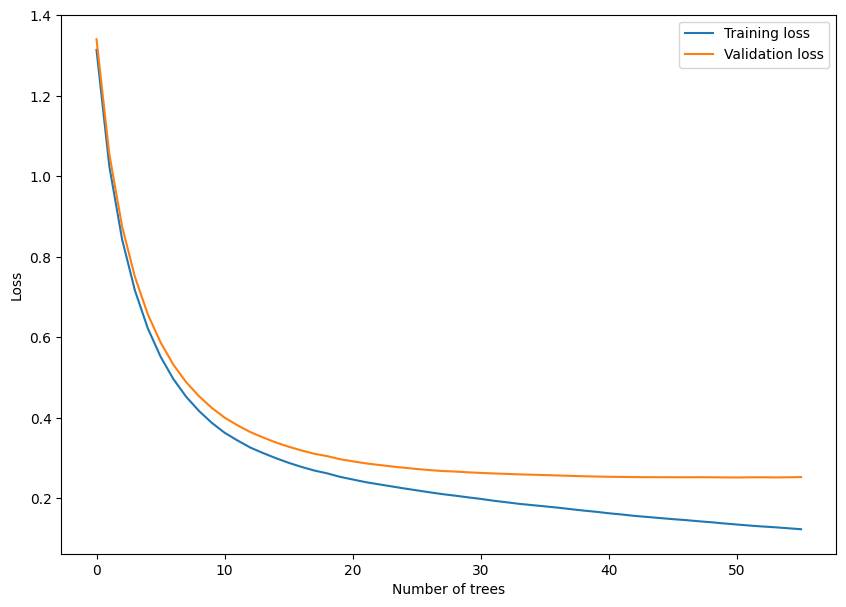

In [ ]:
# Mengambil hasil evaluasi dari model XGBoost yang sudah dilatih
results = xgb_cls.evals_result()
# Membuat figure dengan ukuran 10x7 inci
plt.figure(figsize=(10,7))
# Plotting kurva loss untuk data training
plt.plot(results["validation_0"]["mlogloss"], label="Training loss")
# Plotting kurva loss untuk data validasi
plt.plot(results["validation_1"]["mlogloss"], label="Validation loss")
# Memberikan label pada sumbu x
plt.xlabel("Number of trees")
# Memberikan label pada sumbu y
plt.ylabel("Loss")
# Menampilkan legend untuk membedakan kurva training dan validasi
plt.legend()

Kedua kurva (training dan validation loss) menunjukkan penurunan yang signifikan dari nilai awal sekitar 1.4 hingga di bawah 0.4. Penurunan terjadi sangat cepat di awal (0-10 pohon) kemudian melambat.

Indikasi Performa Model:
* Model menunjukkan pembelajaran yang baik karena kedua loss menurun
* Ada sedikit overfitting karena training loss lebih rendah dari validation loss
* Overfitting masih dalam batas wajar karena gap tidak terlalu besar
* Model mulai stabil setelah 30-40 pohon

## Confusion Matrix

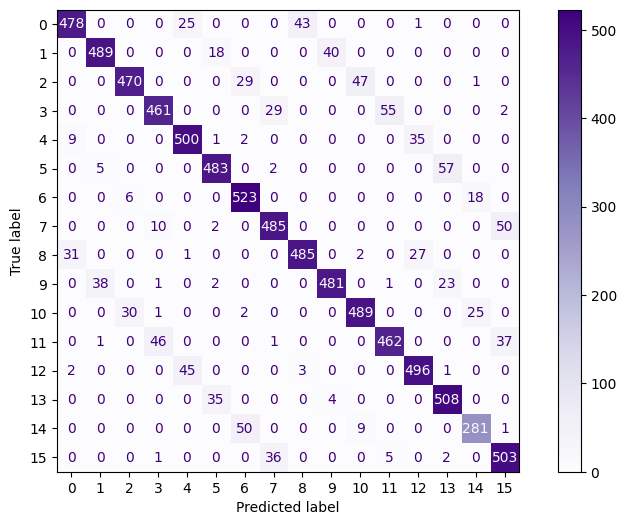

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Purples, normalize=None, ax=ax)
plt.show()

#6 | Tuning

* Mencoba berbagai kombinasi parameter untuk menemukan yang terbaik
* Menggunakan cross-validation untuk menghindari overfitting
* Lebih efisien dari GridSearchCV karena hanya mencoba subset random dari semua kombinasi
* Akan menghasilkan model dengan parameter optimal berdasarkan accuracy

In [ ]:
# Mendefinisikan parameter yang akan dioptimasi dengan range nilainya
param_grid = {
    'max_depth': [3, 5, 7],           # Kedalaman maksimal pohon
    'learning_rate': [0.01, 0.1, 0.3], # Laju pembelajaran
    'subsample': [0.6, 0.8, 1.0],      # Proporsi sampel yang digunakan tiap pohon
    'colsample_bytree': [0.6, 0.8, 1.0] # Proporsi fitur yang digunakan tiap pohon
}

# Inisialisasi model XGBoost dasar
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # Untuk klasifikasi multi-kelas
    num_class=16                # Jumlah kelas output
)

# Melakukan Random Search untuk optimasi hyperparameter
xgb_tuned = RandomizedSearchCV(
    estimator=xgb_model,            # Model yang akan dioptimasi
    param_distributions=param_grid, # Parameter yang akan dicoba
    n_iter=20,                      # Mencoba 20 kombinasi parameter secara random
    cv=5,                           # 5-fold cross validation
    scoring='accuracy',             # Metrik evaluasi menggunakan accuracy
    verbose=2,                      # Level detail output
    n_jobs=-1                       # Menggunakan semua core CPU
)

# Melatih model dengan random search
xgb_tuned.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_class=16, num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.3],
                                        'max_depth': [3, 5, 7],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='accuracy', verbose=2)

In [ ]:
xgb_tuned.best_params_

{'subsample': 0.8,
 'max_depth': 3,
 'learning_rate': 0.3,
 'colsample_bytree': 0.6}

In [ ]:
xgb_tuned.best_score_

0.9004739887635276

Tuned Model Accuracy: 0.89
Tuned Model Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       547
           1       0.92      0.90      0.91       547
           2       0.92      0.87      0.90       547
           3       0.90      0.84      0.87       547
           4       0.87      0.93      0.90       547
           5       0.90      0.90      0.90       547
           6       0.87      0.95      0.91       547
           7       0.87      0.92      0.89       547
           8       0.91      0.90      0.90       546
           9       0.92      0.88      0.90       546
          10       0.91      0.89      0.90       547
          11       0.89      0.85      0.87       547
          12       0.90      0.90      0.90       547
          13       0.87      0.94      0.90       547
          14       0.86      0.84      0.85       341
          15       0.86      0.92      0.89       547

    accuracy      

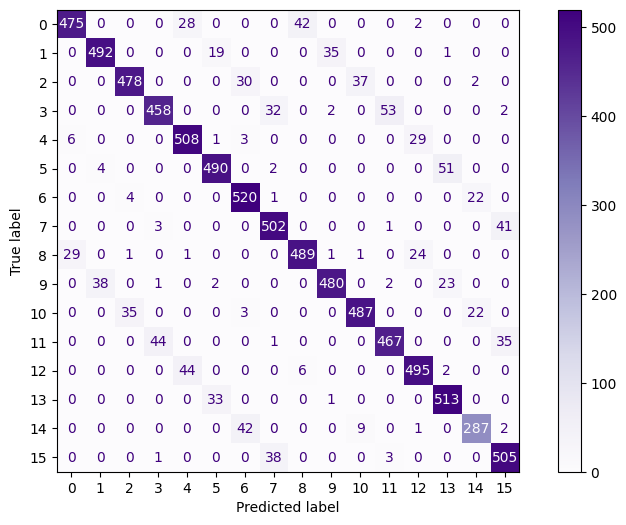

In [ ]:
# Assuming xgb_tuned is already fitted as in your provided code.
y_pred_tuned = xgb_tuned.predict(X_test_scaled)

# Evaluate the tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
report_tuned = classification_report(y_test, y_pred_tuned)

print(f'Tuned Model Accuracy: {accuracy_tuned:.2f}')
print('Tuned Model Classification Report:')
print(report_tuned)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tuned, cmap=plt.cm.Purples, normalize=None, ax=ax)
plt.show()

#7 | Referensi



* [1] “Xgboost Tutorial.” Accessed: Jan. 21, 2025. [Online]. Available: https://www.kaggle.com/code/yasinnsariyildiz/xgboost-tutorial
* [2] “Tutorials - DataCamp Learn.” Accessed: Jan. 21, 2025. [Online]. Available: https://app.datacamp.com/learn/tutorials/xgboost-in-python
* [3] A. Jain, “XGBoost Parameters Tuning: A Complete Guide with Python Codes,” A. Vidhya, 2024, Accessed: Jan. 21, 2025. [Online]. Available: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
* [4] “Personality Prediction (90% Accuracy).” Accessed: Jan. 21, 2025. [Online]. Available: https://www.kaggle.com/code/samanyuk/personality-prediction-90-accuracy


